# <center> Diferenciación Fraccional</center>
---
### <center>Esteban Ortiz Tirado González</center>

<img src="iteso.png" align="center"/>


##### <center>PAP - PROGRAMA DE MODELACION MATEMATICA PARA EL DESARROLLO DE PLANES Y PROYECTOS DE NEGOCIO</center>
#### <center>Otoño 2020</center>

## <center> Conextualización </center>

En este proyecto del PAP, uno de los objetivos generales es construir un modelo de Machine Learning (ML) para el pronóstico de series de tiempo financieras.

Dicho modelo será un **Perceptrón Multicapa**, pero ¿qué es eso?

---


### <center> Perceptrón Multicapa</center>

<img src="perceptronmulti.png" align="center"/>
    
<center>https://cursospython.com/redes-neuronales/</center>



**Características Principales**

- Utilizada para **clasificar** datos que no son linealmente separables
- Minimiza la función Log-loss
- Una capa de entrada, n capas ocultas, una sola salida


### <center> Clasificación de Datos</center>
    
<img src="clasificacion.png" align="center"/>

<center>https://towardsdatascience.com/intuition-behind-model-fitting-overfitting-v-s-underfitting-d308c21655c7</center>

<br/>

Al tratarse de un modelo predictivo, la **memoria** de la serie de tiempo utilizada para entrenar al modelo se vuelve extremadamente importante

## <center>¿Qué tiene que ver todo esto con diferenciación fraccional?

- Una práctica común en ML es pre-procesar los datos para que la serie con la que se va a trabajar sea estacionaria (media y varianza constante)

- Sabemos que las series financieras no son estacionarias (en la gran mayoría de los casos)

- La forma más popular de convertir una serie no estacionaria en estacionaria es mediante las diferencias, es decir los rendimientos (naturales o logarítmicos)

- Al hacer esto, se pierde casi por completo la **memoria** de la serie

- Las series financieras tienen memoria, lo cual es importante considerar si lo que queremos es hacer predicciones sobre ella

- Entonces, si **ganamos estacionariedad perdemos memoria**, pero si conservamos memoria no tenemos estacionariedad

#### <center>¿Habrá una manera de diferenciar, tal que obtengamos una serie estacionaria y conservemos la memoria de la serie original? 

## <center> Recordando Conceptos
    
---

### <center><font color='green'>Serie de Taylor</font>

Una Serie de Taylor es una aproximación mediante la expansión polinomial de una función, evaluada en un punto específico

#### Fórmula

<center>$f(a) + \frac{f'(a)}{1!}(x-a) + \frac{f''(a)}{2!}(x-a)^{2} + \frac{f'''(a)}{3!}(x-a)^{3} + ...$</center>


#### Simplificación

<center>$\sum\limits_{n=0}^{\infty} \frac{f^{n}(a)}{n!}(x-a)^{n}$







### <center><font color='green'>Operador Rezago</font>

Sea **B** el operador rezago, con las siguientes propiedades:

- $B*B = B^{2}$

- $B+B = 2B$

- $B^{k}X_{t} = X_{t-k}$ , for $t>k$ and for all integers $k>0$

<br/>

Ejemplo: $B$ aplicado a una serie de tiempo $X$ 

<center>$(I-B)X_{t} = X_{t} - BX_{t} = X_{t} - X_{t-1}$


Uniendo los conceptos de expansión mediante Serie de Taylor, y el operador rezago $B$ obtenemos lo siguiente:

<center>$(1-B)^{d} = 1 - dB + \frac{d(d-1)}{2!}B^{2} - \frac{d(d-1)(d-2)}{3!}B^{3} + ...$
    
Donde $(1-B)^{d}$ es la **diferenciación** de una serie y $d$ representa el factor de diferenciación que estamos aplicando
    
<br/>

Por lo tanto, los **coeficientes** de cada $B^{n}$ se pueden expresar como

<center> $w_{k} = -w_{k-1}\frac{d-k+1}{k}$
    
Lo cual nos permite utilizar un numero entre $(0,1)$ para el grado de diferenciación $d$ 


## <center>Aplicación en Series Financieras</center>

Ya tenemos la teoría necesaria para encontrar los pesos por los que hay que multiplicar cada obseravción de la serie y diferenciarla fraccionalmente.

<font color='green'>Objetivo:</font> Obtener una serie **estacionaria** que preserve su **memoria** de largo plazo para entrenar nuestro modelo

<font color='green'>Cómo medirlo:</font> Mantener la **mayor** correlación posible entre la serie original y su diferencia y que la prueba ADF sea **menor** al valor límite para cierto nivel de confianza
    
<img src="msftprice.png" align="center"/>

## <center>¿Solución?</center>
<img src="msftret.png" align="center"/>

In [1]:
# Librerías necesarias
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [2]:
# Descarga de datos
msft = yf.Ticker('MSFT')
hist = msft.history(period='10y')
close = pd.DataFrame(np.log(hist.Close))

In [3]:
# Calcular vector w de pesos
# Se incorpora un limite de valor para el peso (threshold) porque en teoría la serie es infinita
def findWeights_FFD(d, length, threshold):
    #set first weight to be a 1 and k to be 1
    w, k = [1.], 1
    w_curr = 1
    #while we still have more weights to process, do the following:
    while(k < length):
        w_curr = (-w[-1]*(d-k+1))/k
        #if the current weight is below threshold, exit loop
        if(abs(w_curr) <= threshold):
            break
        #append coefficient to list if it passes above threshold condition
        w.append(w_curr)
        #increment k
        k += 1
    #make sure to convert it into a numpy array and reshape from a single row to a single
    # column so they can be applied to time-series values easier
    w = np.array(w[::-1]).reshape(-1,1)
    return w

In [4]:
# Diferenciacion Fraccional
def fracdiff_threshold(series, d, threshold):
    # return the time series resulting from (fractional) differencing
    length = len(series)
    weights=findWeights_FFD(d, length, threshold)
    weights = weights[::-1]
    res=0
    for k in range(len(weights)):
        res += weights[k]*series.shift(k).fillna(0)
    return res[len(weights):]

In [12]:
# Prueba de correlacion y estacionariedad
# Se usa ADF para la prueba de estacionariedad
# Muestra de que con d<1 se obtiene estacionariedad y se mantiene una correlación muy alta
def corrvalues(series, dRange, step, threshold):
    difs = pd.DataFrame(series.Close)
    for i in np.arange(dRange[0], dRange[1]+step,step):
      difs['Diff %s'%i] = fracdiff_threshold(close,i,threshold) # Where to set the threshold? More history allows smaller threshold (making the series bigger)
    corr_series = difs.corr().Close
    return corr_series


def plotMemoryVsCorr(result, seriesName):
    fig, ax = plt.subplots(figsize=(14,7))
    ax2 = ax.twinx()  
    color1='xkcd:deep red'; color2='xkcd:cornflower blue'
    ax.plot(result.order,result['adf'],color=color1)
    ax.plot(result.order, result['5%'], color='xkcd:slate')
    ax.plot(result.order, result['1%'], color='xkcd:slate')
    ax2.plot(result.order,result['corr'], color=color2)
    ax.set_xlabel('Order of differencing')
    ax.set_ylabel('ADF', color=color1);ax.tick_params(axis='y', labelcolor=color1)
    ax2.set_ylabel('Corr', color=color2); ax2.tick_params(axis='y', labelcolor=color2)
    plt.title('ADF test statistics and Correlation for %s' % (seriesName))
    plt.show()

In [6]:
def MemoryVsCorr(series, dRange, step, threshold):
    # return a data frame and plot comparing adf statistics and linear correlation
    # for numberPlots orders of differencing in the interval dRange up to a lag_cutoff coefficients
    corr_series = corrvalues(series, dRange, step, threshold)
    interval=np.arange(dRange[0], dRange[1]+step,step)
    result=pd.DataFrame(np.zeros((len(interval),4)))
    result.columns = ['order','adf','corr', '5%']
    result['order']=interval
    for counter,order in enumerate(interval):
        seq_traf=fracdiff_threshold(close,order,threshold)
        res=adfuller(seq_traf, maxlag=1, regression='c') #autolag='AIC'
        result.loc[counter,'adf']=res[0]
        result.loc[counter,'5%']=res[4]['5%']
        result.loc[counter,'1%']=res[4]['1%']
        result.loc[counter,'corr']= corr_series[counter+1]
    plotMemoryVsCorr(result, 'MSFT')
    return result

## <center>Resultados

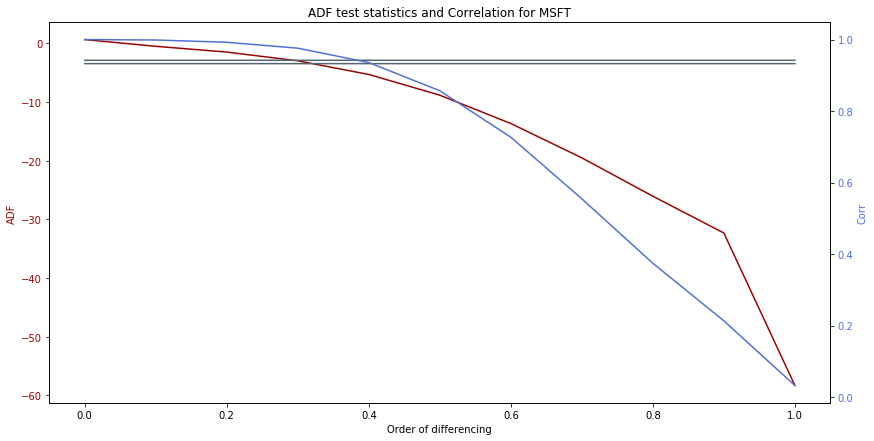

In [13]:
df = MemoryVsCorr(close,(0,1),0.1,1e-4)

In [14]:
df

,order,adf,corr,5%,1%
0,0.0,0.669025,1.000000,-2.862690,-3.432953
1,0.1,-0.477880,0.998831,-2.862977,-3.433603
2,0.2,-1.463356,0.992453,-2.862973,-3.433593
3,0.3,-2.952542,0.975962,-2.862899,-3.433427
4,0.4,-5.281578,0.935720,-2.862835,-3.433281
5,0.5,-8.816548,0.856897,-2.862789,-3.433177
6,0.6,-13.644836,0.726848,-2.862757,-3.433105
7,0.7,-19.504004,0.554513,-2.862736,-3.433056
8,0.8,-26.046957,0.374201,-2.862719,-3.433020
9,0.9,-32.324581,0.213200,-2.862707,-3.432992


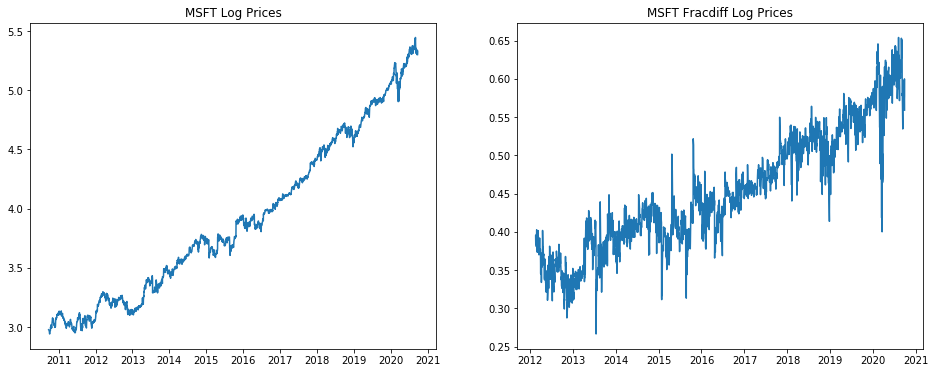

In [20]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(close)
plt.title('MSFT Log Prices')
plt.subplot(1,2,2)
plt.plot(fracdiff_threshold(close,0.33,1e-4))
plt.title('MSFT Fracdiff Log Prices')
plt.show()

## <center>Implementación

In [1]:
def least_diff(series, dRange: tuple, step, threshold, confidence: str):
    '''Function to fractionally differentiate a series using the minimum degree
    possible to make the series stationary.
    Stationarity is determined using ADF test
    Returns result as a DataFrame with the order of differentiation, the ADF test
    and the threshold value for the confidence interval used
    It also returns the differentiated series as a DataFrame
    '''
    interval=np.arange(dRange[0], dRange[1]+step,step)
    result=pd.DataFrame(columns = ['order','adf', confidence])
    deg = interval[0]
    seq_traf=fracdiff_threshold(series,deg,threshold)
    res=adfuller(seq_traf, maxlag=1, regression='c') #autolag='AIC'
    while res[0]>res[4][confidence]:
      deg += step
      res=adfuller(fracdiff_threshold(series,deg,threshold), maxlag=1, regression='c')
    interval=np.arange(deg-step, deg, step/10)
    deg = interval[0]
    seq_traf=fracdiff_threshold(series,deg,threshold)
    res=adfuller(seq_traf, maxlag=1, regression='c') #autolag='AIC'
    while res[0]>res[4][confidence]:
      deg += step/10
      seq_traf=fracdiff_threshold(series,deg,threshold)
      res=adfuller(seq_traf, maxlag=1, regression='c')
    result['order']=[deg]
    result['adf']=[res[0]]
    result[confidence]=[res[4][confidence]]
      
    return result,seq_traf


## <center>Conclusiones

- No es necesario diferenciar con $d=1$ para que la serie sea estacionaria
- Entre menor sea $d$, mayor es la correlación con la serie original (Obvio, ese fue el punto de partida)
- Sorprendentemente no es una técnica muy usada
- La teoría del mercado eficiente es quizá atribuible, en parte, a la eliminación de información en el procesado de datos
- La diferenciación fraccional es una (de muchas) herramienta para generar variables endógenas (feature engineering) con poder predictivo

### <center>¿Dudas?

## <center> ¡Gracias!
    
**Material disponible en:** https://github.com/eortizt/Fracdiff
    
**Contacto:** esteban.otg@gmail.com / if708924@iteso.mx

## <center>Referencias

- Lopez de Prado, M. (2018). Fractionally Differentiated Features. In Advances in Financial Machine Learning (1st ed., pp. 75–90). Wiley.

- Godoy, D. (2019, February 7). Understanding binary cross-entropy / log loss: a visual explanation. Medium. https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a#:%7E:text=Loss%20Function%3A%20Binary%20Cross%2DEntropy%20%2F%20Log%20Loss&text=Reading%20this%20formula%2C%20it%20tells,point%20(y%3D0).a3ac6025181a#:~:text=Loss%20Function%3A%20Binary%20Cross%2DEntropy%20%2F%20Log%20Loss&text=Reading%20this%20formula%2C%20it%20tells,point%20(y%3D0).

- A. (2020, May 25). Redes Neuronales: Qué son, el perceptrón y ejemplos. Cursos Python. https://cursospython.com/redes-neuronales/

- Amarnani, D. (2019, February 8). Welcome and Introduction to Fractional Differencing (FD Part 1). KidQuant. http://kidquant.blogspot.com/2019/02/welcome-and-introduction-to-fractional.html

- Amarnani, D. (2019, February 12). Fractional Differencing Derivation (FD Part 2). KidQuant.
http://kidquant.blogspot.com/2019/02/fractional-differencing-derivation.html

- Amarnani, D. (2019, March 19). Fractional Differencing Implementation (FD Part 3). KidQuant.
http://kidquant.blogspot.com/2019/03/fractional-differencing-implementation.html

- Kuttruf, S. (2019, February 27). Preserving Memory in Stationary Time Series - Towards Data Science. Medium. https://towardsdatascience.com/preserving-memory-in-stationary-time-series-6842f7581800

- Kuttruf, S. (2019) Python code for fractional differencing of pandas time series. https://gist.github.com/skuttruf/fb82807ab0400fba51c344313eb43466

- Amarnani, D. (2019) Post1_Fractional_Differencing.ipynb https://github.com/Dhiraj96/blog_posts/blob/master/post_1%2C2%2C3/Post1_Fractional_Differencing.ipynb